In [1]:
from data import *
from encoders import *
from config import *
from models import *
from evals import *
print("using device: ", device)

import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import importlib
# import models
# importlib.reload(models)


using device:  cpu


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### load local data files

In [2]:
# ugly engineering here
df = pd.read_csv('../../data/HR_events.csv')
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")
df_y = df_y[['VitalID', 'Died']]
df = df.merge(df_y, on='VitalID', how='left')
df['text'] = df['Died'].apply(lambda x: 'This infant will die in 7 days. ' if x == 1 else 'This infant will survive. ')
# df['text'] = df['text'] +' '+ df['event_description'].astype(str)
df['label'] = df.index.to_series()
# df_train, df_test = train_test_split(df, test_size=0.2)    

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['text'])    
# df_train['text'] = df_train['text'] +' '+ df_train['label'].astype(str)
# df_test['text'] = df_test['text'] +' '+ df_test['label'].astype(str)


In [3]:
df_new = df_train
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_train = torch.tensor(df_new_y.values)
ts_df_train = df_new.loc[:,'1':'300']


df_new = df_test
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_test = torch.tensor(df_new_y.values)
ts_df_test = df_new.loc[:,'1':'300']

txt_ls = ['will die', 'will survive']

### prepare datasets and model training

In [4]:
# text_encoder_name = 'dmis-lab/biobert-base-cased-v1.2'
text_encoder_name = 'sentence-transformers/all-mpnet-base-v2'
ts_encoder_name = 'hr_vae_linear_medium'
ts_f_train, tx_f_train, labels_train = get_features(df_train,ts_encoder_name,text_encoder_name)
train_dataloader = CLIPDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=128)

ts_f_test, tx_f_test, labels_test = get_features(df_test, ts_encoder_name,text_encoder_name)
test_dataloader = CLIPDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=128)


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [8]:
overwrite = False
model_path = './results/clip_hr_death.pth' 
loss_path = './results/clip_hr_death_losses.pth'
eval_metrics_path = './results/clip_hr_death_eval_metrics.pth'
# Initialize model
model = CLIPModel(
        ts_dim=ts_f_train.shape[1],    # 32
        text_dim=tx_f_train.shape[1],  # 768
        projection_dim=128
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=50,          # Number of epochs to wait before reducing LR
    min_lr=1e-10         # Don't reduce LR below this value
)

Layer (type:depth-idx)                   Param #
CLIPModel                                1
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       4,224
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       33,024
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       32,896
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       16,512
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       98,432
│    └─LeakyReLU: 2-9                    --
│    └─Linear: 2-10                      33,024
│    └─LeakyReLU: 2-11                   --
│    └─Linear: 2-12                      65,792
│    └─LeakyReLU: 2-13                   --
│    └─Linear: 2-14                      32,896
│    └─LeakyReLU: 2-15                   --
│    └─Linear: 2-16                      16,512
Total params: 333,313
Trainable params: 333,313
Non-trainable params: 0


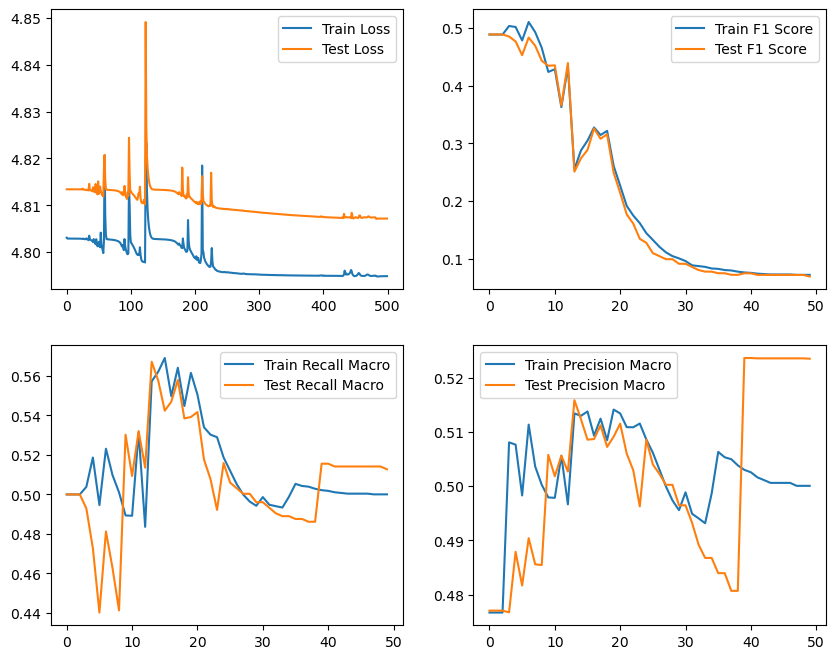

In [9]:

if overwrite or not os.path.exists(model_path):
    num_epochs = 10
    num_saves = 50 # total epochs will be num_saves * num_epochs
    train_losses=[]
    test_losses=[]
    train_eval_metrics_list = []
    test_eval_metrics_list = []
    for i in range(num_saves): 
        train_losses_tmp, test_losses_tmp = train(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                num_epochs, 
                                                device)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        
        train_eval_metrics = eval_model(model, y_true_train, ts_df_train, txt_ls, ts_encoder_name, text_encoder_name)
        test_eval_metrics = eval_model(model, y_true_test, ts_df_test, txt_ls, ts_encoder_name, text_encoder_name)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses }, loss_path)
        # save train_eval_metrics_list and test_eval_metrics_list
        torch.save({
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_metrics_path)  
    
else:
    model.load_state_dict(torch.load(model_path))
    train_losses = torch.load(loss_path)['train_losses']
    test_losses = torch.load(loss_path)['test_losses']
    train_eval_metrics_list = torch.load(eval_metrics_path)['train_evals']
    test_eval_metrics_list = torch.load(eval_metrics_path)['test_evals']

    train_f1_scores = [eval_metrics['f1_macro'] for eval_metrics in train_eval_metrics_list]
    test_f1_scores = [eval_metrics['f1_macro'] for eval_metrics in test_eval_metrics_list]
    train_recall_macro = [eval_metrics['recall_macro'] for eval_metrics in train_eval_metrics_list]
    test_recall_macro = [eval_metrics['recall_macro'] for eval_metrics in test_eval_metrics_list]
    train_precision_macro = [eval_metrics['precision_macro'] for eval_metrics in train_eval_metrics_list]
    test_precision_macro = [eval_metrics['precision_macro'] for eval_metrics in test_eval_metrics_list]

    # plot 2 by 2 axes of losses, f1, recall, precision 
    # use axs to plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].plot(test_losses, label='Test Loss')
    axs[0, 0].legend()
    axs[0, 1].plot(train_f1_scores, label='Train F1 Score')
    axs[0, 1].plot(test_f1_scores, label='Test F1 Score')
    axs[0, 1].legend()
    axs[1, 0].plot(train_recall_macro, label='Train Recall Macro')
    axs[1, 0].plot(test_recall_macro, label='Test Recall Macro')
    axs[1, 0].legend()
    axs[1, 1].plot(train_precision_macro, label='Train Precision Macro')
    axs[1, 1].plot(test_precision_macro, label='Test Precision Macro')
    axs[1, 1].legend()
    plt.show()


In [7]:
train_eval_metrics_list

[{'accuracy': 0.9533468559837728,
  'precision_macro': 0.4766734279918864,
  'recall_macro': 0.5,
  'f1_macro': 0.48805815160955346,
  'precision_weighted': 0.9088702278141444,
  'recall_weighted': 0.9533468559837728,
  'f1_weighted': 0.9305774087484388,
  'confusion_matrix': array([[   0,   69],
         [   0, 1410]]),
  'roc_auc': 0.4238462329119128,
  'prc_auc': None,
  'per_class': {'will die': {'precision': 0.0,
    'recall': 0.0,
    'f1': 0.0,
    'support': 69},
   'will survive': {'precision': 0.9533468559837728,
    'recall': 1.0,
    'f1': 0.9761163032191069,
    'support': 1410}}},
 {'accuracy': 0.9533468559837728,
  'precision_macro': 0.4766734279918864,
  'recall_macro': 0.5,
  'f1_macro': 0.48805815160955346,
  'precision_weighted': 0.9088702278141444,
  'recall_weighted': 0.9533468559837728,
  'f1_weighted': 0.9305774087484388,
  'confusion_matrix': array([[   0,   69],
         [   0, 1410]]),
  'roc_auc': 0.5669159214718882,
  'prc_auc': None,
  'per_class': {'will d